In [239]:
from subprocess import Popen, PIPE

def flatten_list_of_strings(args):
    output = ''
    for s in args:
        output += s
        output += ' '
    return output

def str_to_num(s):
    if '.' in s:
        return float(s)
    else:
        return int(s)

class ExpRunner():

    def __init__(self, filter_name, input_image_path, implementation, output_image_dir, verbose=False):
        self.tp_exec = '../build/tp2'
        self.exp_results = {'filter_name': filter_name, 'implementation': implementation}
        self.run_args = [self.tp_exec, 
                         filter_name, 
                         input_image_path, 
                         "-i", implementation, 
                         "-o", output_image_dir]
        self.verbose = verbose
        
    def exp_keys(self):
        '''
        ["Comienzo",
                "Fin",
                "# de ciclos insumidos totales",  
                "# de ciclos insumidos por llamada"]
        '''
        return ["# de ciclos insumidos totales"] # por ahora solo nos interesa esta

    def run_executable(self):
        p = Popen(self.run_args, stdout=PIPE, bufsize=1)
        with p.stdout:
            for line in iter(p.stdout.readline, b''):
                line = line.decode("utf-8")
                try:
                    key, val = line[:-1].split(':')
                    key = key.strip(" ")
                    if(key in self.exp_keys()):
                        self.exp_results[key] = str_to_num(val)
                except:
                    pass
        p.wait() # wait for the subprocess to exit

    def print_help(self):
        self.run_executable([self.tp_exec, "-h"])
        return
            
    def run(self):
        if self.verbose:
            print("Run command:")
            print(flatten_list_of_strings(self.run_args))
            print
            
        self.run_executable()
        return dict(self.exp_results)

### Cargar varias exp en un dataframe

In [240]:
import pandas as pd
from scipy import stats
import numpy as np

def get_exps(exp_runner, sample_size, z_score_threshold=2.5):

    # correr exps
    exps = pd.DataFrame([exp_runner.run() for i in range(sample_size)])

    # descartar outliers
    exps = exps[stats.zscore(np.abs(exps['# de ciclos insumidos totales'])) < z_score_threshold]
    
    return exps

## obtener tamaños y tiempos de exps

In [269]:
def qty_pixels(img_name):
    rows, cols = img_name.split('.')[1].split('x')
    return int(rows) * int(cols)

In [257]:
import os
# img_names = ["Wargames", "NoCountryForOldMen"]
img_dir="../tests/data/imagenes_a_testear/"

sizes = []
times = []
for img_name in os.listdir(img_dir):
    if "Wargames" in img_name:
        er = ExpRunner(filter_name = "Sharpen",
            input_image_path=img_dir+img_name,
            implementation = "asm", 
            output_image_dir = "./exp_output_images/")

        exps = get_exps(er, 30, z_score_threshold=2.5)
        sizes.append(qty_pixels(img_name))
        times.append(exps["# de ciclos insumidos totales"].mean())

sizes_vs_times = list(zip(sizes,times))
sizes_vs_times.sort(key=lambda tup: tup[0])

## plotear resultados

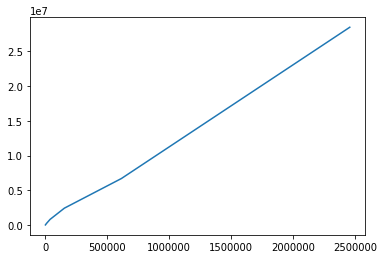

In [268]:
import matplotlib.pyplot as plt
sizes, times = zip(*sizes_vs_times)
plt.plot(sizes, times)

# TODO: poder correr distintas implementaciones